In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
%cd /content/drive/MyDrive/dacon

/content/drive/MyDrive/dacon


In [4]:
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])



# 전처리 후 학습 데이터 확인
train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,0.167046,-0.121165,-0.015962,-0.829869,0.786885,1.038128,-0.669045,-0.024844,0.090246,1,0,1.400157,5,0
1,a0a60abb,0.621553,0.357181,1.152389,0.316456,0.498363,0.212579,2.261009,-0.594656,-0.702077,2,0,-0.711163,6,1
2,b9f171ae,1.530566,-1.675788,0.400155,-0.591616,0.065581,0.487762,1.939124,-0.024844,0.090246,2,1,-1.414937,7,1
3,5dc0ba8b,-1.650980,0.476767,0.877690,-0.218820,0.931145,1.588495,-0.489192,-1.734280,-0.702077,1,0,-0.711163,0,1
4,65c83654,-1.196473,-1.197443,2.130972,-0.431503,0.931145,-0.612970,0.691049,-0.594656,0.090246,2,0,0.696384,0,1


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# 로지스틱 회귀 모델 초기화 및 학습
gb_model = GradientBoostingClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100, 500],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
              'subsample':[0.5, 0.7, 1.0],
              'max_depth':[4, 7, 10],
              'random_state' : [42]
             }
f1_scorer = make_scorer(f1_score, average='macro')
gb_grid = GridSearchCV(gb_model, param_grid, scoring=f1_scorer, verbose=2)
gb_grid.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = gb_grid.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
print(f'best accuracy : {gb_grid.best_score_}')
print('best param : ', gb_grid.best_params_)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))


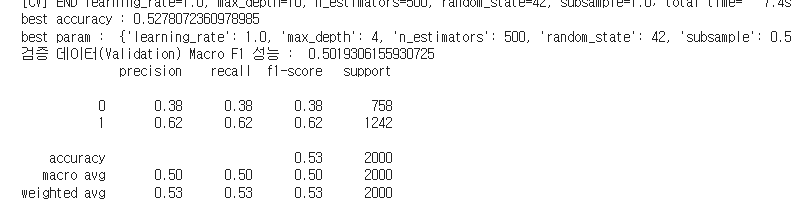

In [ ]:
# 테스트 데이터에 대한 예측 수행
test_X = test.drop(columns=['user_id'])  # user_id는 제외하고 특성 데이터로 사용
test_predictions = gb_grid.predict(test_X)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

import os
model = 'gb'
path = f"./{model}"
if not os.path.exists(path):
  os.mkdir(path)
# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = f'{path}/baseline_submit({model}_tuned_model_noPreprocessing).csv'
sample.to_csv(submit_path, index=False)

sample.head()

,user_id,target
0,0001d6e9,0
1,0002c77d,1
2,0002df5b,0
3,000b6068,1
4,00184a0c,1


# 클러스터링 3

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

# 클러스터링할 열 선택 (여기서는 'average_time_per_learning_session'만 선택)
X = train[['average_time_per_learning_session']]
X_test = test[['average_time_per_learning_session']]

# 데이터 표준화 (스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# KMeans 클러스터링 모델 생성 및 학습
kmeans = KMeans(n_clusters=3)  # 클러스터 개수 설정
kmeans.fit(X_scaled)

# 클러스터링 결과를 데이터프레임에 추가
train['average_time_per_learning_session'] = kmeans.labels_
test['average_time_per_learning_session'] = kmeans.predict(X_test_scaled)

# 각 클러스터의 중심점 확인
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:", cluster_centers)

# 결과 출력
print(train)

from sklearn.preprocessing import StandardScaler, LabelEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]

# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

c:\Users\dbswo\anaconda3\envs\subs_predict\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Centers: [[ 89.03686606]
 [ 23.12694871]
 [204.71736801]]
       user_id  subscription_duration  recent_login_time  average_login_time  \
0     b919c29d                     13                 14           14.946163   
1     a0a60abb                     16                 18           18.453224   
2     b9f171ae                     22                  1           16.195228   
3     5dc0ba8b                      1                 19           17.628656   
4     65c83654                      4                  5           21.390656   
...        ...                    ...                ...                 ...   
9995  ae6b76bc                     22                 29           14.727623   
9996  24588752                     10                 11           19.374054   
9997  e4622a54                      7                 27           18.240978   
9998  e07fbad9                     11                  7           18.783800   
9999  e12dcb55                     10                 

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,0.167046,-0.121165,-0.015962,1,0.786885,1.038128,-0.669045,-0.024844,0.090246,1,0,1.400157,0.647774,0
1,a0a60abb,0.621553,0.357181,1.152389,0,0.498363,0.212579,2.261009,-0.594656,-0.702077,2,0,-0.711163,1.080460,1
2,b9f171ae,1.530566,-1.675788,0.400155,1,0.065581,0.487762,1.939124,-0.024844,0.090246,2,1,-1.414937,1.513146,1
3,5dc0ba8b,-1.650980,0.476767,0.877690,1,0.931145,1.588495,-0.489192,-1.734280,-0.702077,1,0,-0.711163,-1.515656,1
4,65c83654,-1.196473,-1.197443,2.130972,1,0.931145,-0.612970,0.691049,-0.594656,0.090246,2,0,0.696384,-1.515656,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 초기화 및 학습
xgb_model = XGBClassifier()
param_grid = {'n_estimators': [50, 100, 500],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
              'subsample':[0.5, 0.7, 1.0],
              'max_depth':[4, 7, 10],
              'random_state' : [42]
             }
f1_scorer = make_scorer(f1_score, average='macro')
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring=f1_scorer)
xgb_grid.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = xgb_grid.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
print(f'best accuracy : {xgb_grid.best_score_}')
print('best param : ', xgb_grid.best_params_)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))


best accuracy : 0.5161164114594318
best param :  {'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 500, 'random_state': 42, 'subsample': 0.7}
검증 데이터(Validation) Macro F1 성능 :  0.4862855544296425
              precision    recall  f1-score   support

           0       0.36      0.36      0.36       758
           1       0.61      0.62      0.61      1242

    accuracy                           0.52      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.52      0.52      0.52      2000



![image.png](attachment:image.png)

![![image.png](attachment:image.png)](attachment:image.png)

## 23일
#### 제대로 클러스터링한거 넣어서 점수 다시 확인
#### xgb 튜닝하고 클러스터링한거 넣어서 점수 확인 - 여기까지 3번
#### 모델별로 돌리고 가장 높은거 2개 넣어보기
#### 성능 좋은 모델 2개 선정하고 이것에 대해서만 전처리 & 파라미터 튜닝 계속 해보기

## 24일
#### 이상치 제거 평균 학습 세션, 달성률에 대해 적용하고 확인해보기

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 초기화 및 학습
xgb_model = XGBClassifier(learning_rate = 1.0, max_depth = 7, n_estimators = 50, subsample = 1.0, random_state=42)

xgb_model.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = xgb_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))


검증 데이터(Validation) Macro F1 성능 :  0.494071527969833
              precision    recall  f1-score   support

           0       0.37      0.32      0.34       758
           1       0.62      0.67      0.64      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.54      0.53      2000

